# import packages and files

In [1]:
import numpy as np
import sys
import xarray as xr
import glob
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline
import ecco_access as ea

import warnings
warnings.filterwarnings('ignore')

from os.path import join,expanduser,exists,split
user_home_dir = expanduser('~')

# indicate mode of access
# options are:
# 'download': direct download from internet to your local machine
# 'download_ifspace': like download, but only proceeds 
#                     if your machine have sufficient storage
# 's3_open': access datasets in-cloud from an AWS instance
# 's3_open_fsspec': use jsons generated with fsspec and 
#                   kerchunk libraries to speed up in-cloud access
# 's3_get': direct download from S3 in-cloud to an AWS instance
# 's3_get_ifspace': like s3_get, but only proceeds if your instance 
#                   has sufficient storage
access_mode = 's3_open_fsspec'

In [2]:
# setting up a dask LocalCluster
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 61.46 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45001,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 61.46 GiB
Comm: tcp://127.0.0.1:36321,Total threads: 2
Dashboard: http://127.0.0.1:36985/status,Memory: 15.37 GiB
Nanny: tcp://127.0.0.1:39671,


Task exception was never retrieved
future: <Task finished name='Task-607651' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:2199> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py", line 2208, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-607662' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:2199> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py", line 2208, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-607663' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/li

In [3]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Seawater density (kg/m^3)
rhoconst = 1029
## needed to convert surface mass fluxes to volume fluxes

# Heat capacity (J/kg/K)
c_p = 3994

# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62
zeta1 = 0.6
zeta2 = 20.0

In [5]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to /efs_ecco/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join('/efs_ecco','ECCO_V4r4_PODAAC')

# for access_mode = 's3_open_fsspec', need to specify the root directory 
# containing the jsons
jsons_root_dir = join('/efs_ecco','mzz-jsons')

In [6]:
## access datasets needed for this tutorial

ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                   "ECCO_L4_OCEAN_3D_TEMPERATURE_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_SSH_LLC0090GRID_SNAPSHOT_V4R4",\
                   "ECCO_L4_TEMP_SALINITY_LLC0090GRID_SNAPSHOT_V4R4"]
StartDate = '2010-01'
EndDate = '2010-12'
files_dict = ea.ecco_podaac_to_xrdataset(ShortNames_list,\
                                            StartDate=StartDate,EndDate=EndDate,\
                                            mode=access_mode,\
                                            download_root_dir=ECCO_dir,\
                                            max_avail_frac=0.5,\
                                            jsons_root_dir=jsons_root_dir)

In [7]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

In [108]:
time_length = 12  # number of time steps we run

# load the ecco grid

In [8]:
ecco_grid = files_dict[ShortNames_list[0]]
ecco_grid

<xarray.Dataset> Size: 89MB
Dimensions:  (tile: 13, j: 90, i: 90, k: 50, k_p1: 51, nb: 4, j_g: 90, i_g: 90,
              nv: 2, k_l: 50, k_u: 50)
Coordinates: (12/20)
    XC       (tile, j, i) float32 421kB ...
    XC_bnds  (tile, j, i, nb) float32 2MB ...
    XG       (tile, j_g, i_g) float32 421kB ...
    YC       (tile, j, i) float32 421kB ...
    YC_bnds  (tile, j, i, nb) float32 2MB ...
    YG       (tile, j_g, i_g) float32 421kB ...
    ...       ...
  * j_g      (j_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_l      (k_l) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_p1     (k_p1) int32 204B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
  * k_u      (k_u) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nb, nv
Data variables: (12/21)
    CS       (tile, j, i) float32 421kB ...
    Depth    (tile, j, i) float32 421kB ...
    PHrefC   (k) float32 200B ...
    PHrefF   (k_p1) float32 204B ...
    SN       (tile, j, i) float32 421kB ...
    drC      (k_p1) float32 204B ...
    ...       ...
    maskS    (k, tile, j_g, i) bool 5MB ...
    maskW    (k, tile, j, i_g) bool 5MB ...
    rA       (tile, j, i) float32 421kB ...
    rAs      (tile, j_g, i) float32 421kB ...
    rAw      (tile, j, i_g) float32 421kB ...
    rAz      (tile, j_g, i_g) float32 421kB ...
Attributes: (12/58)
    Conventions:                     CF-1.8, ACDD-1.3
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the Lat-Lon...
    uuid:                            87ff7d24-86e5-11eb-9c5f-f8f21e2ee3e0

# volume

In [9]:
vol = (ecco_grid.rA*ecco_grid.drF*ecco_grid.hFacC).transpose('tile','k','j','i').compute()

In [10]:
year_start = 2010
year_end = 2010

In [11]:
# open ETAN snapshots (beginning of each month)

ecco_monthly_SSH = (files_dict[ShortNames_list[-2]]['ETAN']).to_dataset()
ecco_monthly_THETA = (files_dict[ShortNames_list[-1]]['THETA']).to_dataset()
ecco_monthly_snaps = xr.merge((ecco_monthly_SSH,ecco_monthly_THETA))

# time mask for snapshots
time_snap_mask = np.logical_and(ecco_monthly_snaps.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                ecco_monthly_snaps.time.values < np.datetime64(str(year_end+1)+'-01-02','ns'))

ecco_monthly_snaps = ecco_monthly_snaps.isel(time=time_snap_mask)

In [12]:
# print time range of monthly snapshots
print(ecco_monthly_snaps.time.isel(time=[0, -1]).values)

['2010-01-01T00:00:00.000000000' '2011-01-01T00:00:00.000000000']


In [13]:
# find the record of the last ETAN snapshot
last_record_date = ecco_monthly_snaps.time[-1].values
print(last_record_date)
last_record_year = str(last_record_date)[:4]

2011-01-01T00:00:00.000000000


# open the monthly mean data

In [14]:
## Load ECCO variables
ecco_vars_int = (files_dict[ShortNames_list[1]])
ecco_vars_sfc = (files_dict[ShortNames_list[2]])
ecco_monthly_mean = xr.merge((ecco_vars_int,ecco_vars_sfc[['TFLUX','oceQsw']]))

# time mask for monthly means
time_mean_mask = np.logical_and(ecco_monthly_mean.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                ecco_monthly_mean.time.values < np.datetime64(str(year_end+1)+'-01-01','ns'))

ecco_monthly_mean = ecco_monthly_mean.isel(time=time_mean_mask)

In [15]:
print(ecco_monthly_mean.time.isel(time=[0, -1]).values)

['2010-01-16T12:00:00.000000000' '2010-12-16T12:00:00.000000000']


In [16]:
print('Number of monthly mean records: ', len(ecco_monthly_mean.time))
print('Number of monthly snapshot records: ', len(ecco_monthly_snaps.time))

Number of monthly mean records:  12
Number of monthly snapshot records:  13


In [17]:
# Drop superfluous coordinates (We already have them in ecco_grid)
ecco_monthly_mean = ecco_monthly_mean.reset_coords(drop=True)

# merge the monthly mean and snapshot data

In [18]:
ds = xr.merge([ecco_monthly_mean,
               ecco_monthly_snaps.rename({'time':'time_snp','ETAN':'ETAN_snp', 'THETA':'THETA_snp'})])

In [19]:
# Change time axis of the snapshot variables
ds.time_snp.attrs['c_grid_axis_shift'] = 0.5

In [20]:
grid = ecco.get_llc_grid(ds)

# calculate dt for time averaging

In [21]:
delta_t = grid.diff(ds.time_snp, 'T', boundary='fill', fill_value=np.nan)

# Convert to seconds
delta_t = delta_t.astype('f4') / 1e9

# total heat tendency

In [22]:
# Calculate the s*theta term
sTHETA = ds.THETA_snp*(1+ds.ETAN_snp/ecco_grid.Depth)

In [23]:
# Total tendency (psu/s)
G_total = sTHETA.diff(dim='time_snp')/np.expand_dims(delta_t.values,axis=(1,2,3,4))

# re-assign and rename time coordinate
G_total = G_total.rename({'time_snp':'time'})
G_total = G_total.assign_coords({'time':delta_t.time.values})

In [24]:
G_total

<xarray.DataArray (time: 12, k: 50, tile: 13, j: 90, i: 90)> Size: 253MB
array([[[[[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [ 2.43622281e-07,  2.27960484e-07,  2.21634693e-07, ...,
            3.04677087e-07,  3.18085370e-07,  3.48733522e-07],
          [ 1.84057740e-07,  1.77129763e-07,  1.75630305e-07, ...,
            2.80752431e-07,  2.96650910e-07,  3.31482227e-07],
          [ 1.50231656e-07,  1.58938690e-07,  1.72411859e-07, ...,
            2.58836565e-07,  2.76765576e-07,  3.08911609e-07]],

         [[ 1.59305259e-07,  1.75521521e-07,  1.82059523e-07, ...,
            2.38721356e-07,  2.52470983e-07,  2.76169118e-07],
          [ 1.81913364e-07,  1.87130993e-07,  1.85633937e-07, ...,
            2.14456776e-07,  2.22531881e-07,  2.42518411e-07],
          [ 2.04634063e-07,  2.00448397e-07,  1.93433181e-07, ...,
            1.89932351e-07,  1.96716641e-07,  2.21304234e-07],
...
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]]]]],
      dtype=float32)
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    Z        (k) float32 200B ...
  * time     (time) datetime64[ns] 96B 2010-01-16T12:00:00 ... 2010-12-16T12:...

In [25]:
# The weights are just the number of seconds per month divided by total seconds
month_length_weights = delta_t / delta_t.sum()

In [26]:
# The weighted mean weights by the length of each month (in seconds)
G_total_mean = (G_total*month_length_weights).sum('time').compute()

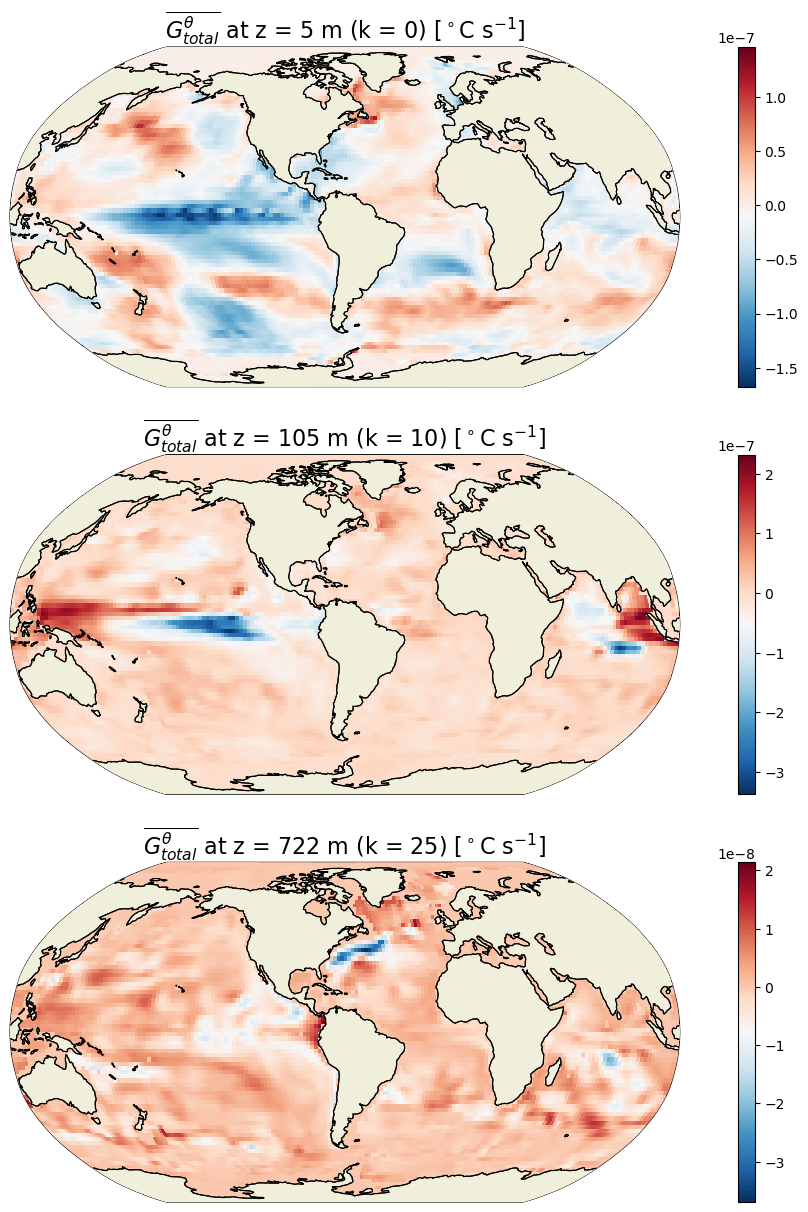

In [27]:
plt.figure(figsize=(15,15))

for idx, k in enumerate([0,10,25]):
    p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_total_mean.isel(k=k),show_colorbar=True,
                                      cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2, subplot_grid=[3,1,idx+1]);
    p[1].set_title(r'$\overline{G^\theta_{total}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
                   %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

# how much did theta change over the time period?

In [28]:
# The number of seconds in the entire period
seconds_in_entire_period = \
    float(ds.time_snp[-1] - ds.time_snp[0])/1e9
print ('seconds in analysis period: ', seconds_in_entire_period)

# which is also the sum of the number of seconds in each month
print('Sum of seconds in each month ', delta_t.sum().values)

seconds in analysis period:  31536000.0
Sum of seconds in each month  31536000.0


In [29]:
THETA_delta = G_total_mean*seconds_in_entire_period

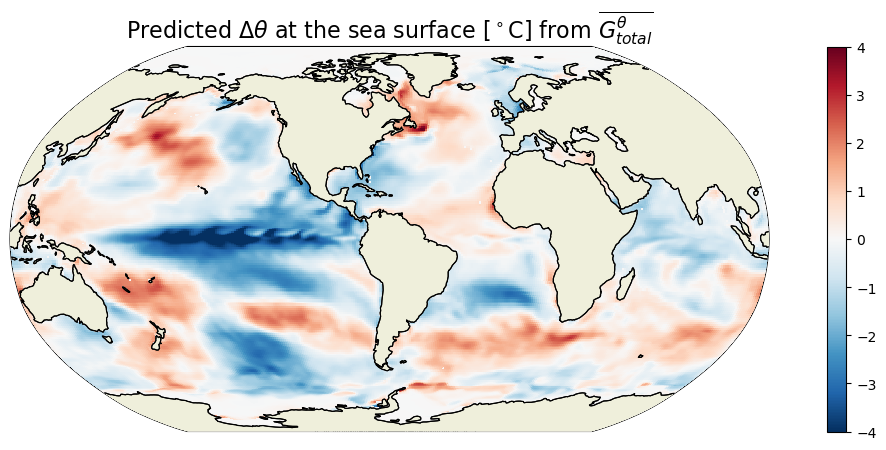

In [30]:
plt.figure(figsize=(15,5));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              THETA_delta.isel(k=0),show_colorbar=True,\
                              cmin=-4, cmax=4, \
                              cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2);
plt.title(r'Predicted $\Delta \theta$ at the sea surface [$^\circ$C] from $\overline{G^\theta_{total}}$',fontsize=16);

In [31]:
THETA_delta_method_2 = ds.THETA_snp.isel(time_snp=-1) - ds.THETA_snp.isel(time_snp=0)


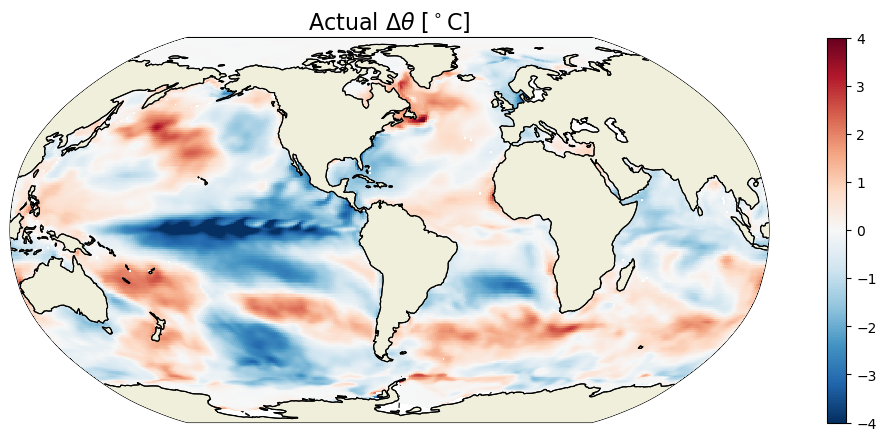

In [32]:
plt.figure(figsize=(15,5));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              THETA_delta_method_2.isel(k=0),show_colorbar=True,\
                              cmin=-4, cmax=4, \
                              cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2);
plt.title(r'Actual $\Delta \theta$ [$^\circ$C]', fontsize=16);

# do some calculations of convergences

In [33]:
def da_replace_at_indices(da,indexing_dict,replace_values):
    # replace values in xarray DataArray using locations specified by indexing_dict
    array_data = da.data
    indexing_dict_bynum = {}
    for axis,dim in enumerate(da.dims):
        if dim in indexing_dict.keys():
            indexing_dict_bynum = {**indexing_dict_bynum,**{axis:indexing_dict[dim]}}
    ndims = len(array_data.shape)
    indexing_list = [':']*ndims
    for axis in indexing_dict_bynum.keys():
        indexing_list[axis] = indexing_dict_bynum[axis]
    indexing_str = ",".join(indexing_list)

    # using exec isn't ideal, but this works for both NumPy and Dask arrays
    exec('array_data['+indexing_str+'] = replace_values')

    return da


def diff_2d_flux_llc90(flux_vector_dict):
    """
    A function that differences flux variables on the llc90 grid.
    Can be used in place of xgcm's diff_2d_vector.
    """

    u_flux = flux_vector_dict['X']
    v_flux = flux_vector_dict['Y']

    u_flux_padded = u_flux.pad(pad_width={'i_g':(0,1)},mode='constant',constant_values=np.nan)\
                            .chunk({'i_g':u_flux.sizes['i_g']+1})
    v_flux_padded = v_flux.pad(pad_width={'j_g':(0,1)},mode='constant',constant_values=np.nan)\
                            .chunk({'j_g':v_flux.sizes['j_g']+1})


    # u flux padding
    for tile in range(0,3):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              u_flux.isel(tile=tile+3,i_g=0).data)
    for tile in range(3,6):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              v_flux.isel(tile=12-tile,j_g=0,i=slice(None,None,-1)).data)
    u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':'6','i_g':'-1'},\
                                          u_flux.isel(tile=7,i_g=0).data)
    for tile in range(7,9):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              u_flux.isel(tile=tile+1,i_g=0).data)
    for tile in range(10,12):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              u_flux.isel(tile=tile+1,i_g=0).data)

    # v flux padding
    for tile in range(0,2):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              v_flux.isel(tile=tile+1,j_g=0).data)
    v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':'2','j_g':'-1'},\
                                          u_flux.isel(tile=6,j=slice(None,None,-1),i_g=0).data)
    for tile in range(3,6):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              v_flux.isel(tile=tile+1,j_g=0).data)
    v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':'6','j_g':'-1'},\
                                          u_flux.isel(tile=10,j=slice(None,None,-1),i_g=0).data)
    for tile in range(7,10):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              v_flux.isel(tile=tile+3,j_g=0).data)
    for tile in range(10,13):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              u_flux.isel(tile=12-tile,j=slice(None,None,-1),i_g=0).data)

    # take differences
    diff_u_flux = u_flux_padded.diff('i_g')
    diff_v_flux = v_flux_padded.diff('j_g')

    # include coordinates of input DataArrays and correct dimension/coordinate names
    diff_u_flux = diff_u_flux.assign_coords(u_flux.coords).rename({'i_g':'i'})
    diff_v_flux = diff_v_flux.assign_coords(v_flux.coords).rename({'j_g':'j'})

    diff_flux_vector_dict = {'X':diff_u_flux,'Y':diff_v_flux}

    return diff_flux_vector_dict

In [34]:
ecco_grid.hFacC

<xarray.DataArray 'hFacC' (k: 50, tile: 13, j: 90, i: 90)> Size: 21MB
[5265000 values with dtype=float32]
Coordinates:
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    Z        (k) float32 200B ...
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    comment:                Tracer grid cells may be fractionally closed in t...
    coverage_content_type:  modelResult
    long_name:              vertical open fraction of tracer grid cell
    units:                  1

In [35]:
# Set fluxes on land to zero (instead of NaN)
ds['ADVx_TH'] = ds.ADVx_TH.where(ecco_grid.hFacW.values > 0,0)
ds['ADVy_TH'] = ds.ADVy_TH.where(ecco_grid.hFacS.values > 0,0)
ds['ADVr_TH'] = ds.ADVr_TH.where(ecco_grid.hFacC.values > 0,0)

# transpose dimensions for xgcm (see note below)
ds['ADVr_TH'] = ds.ADVr_TH.transpose('time','tile','k_l','j','i')

# re-chunk arrays for better performance
ds['ADVx_TH'] = ds['ADVx_TH'].chunk({'time':1,'k':-1,'tile':-1,'j':-1,'i_g':-1})
ds['ADVy_TH'] = ds['ADVy_TH'].chunk({'time':1,'k':-1,'tile':-1,'j_g':-1,'i':-1})
ds['ADVr_TH'] = ds['ADVr_TH'].chunk({'time':1,'tile':-1,'k_l':-1,'j':-1,'i':-1})


# create pickled object with pointers to original flux files
# import pickle

In [36]:
import pickle

In [37]:
ecco_vars_int_pickled = pickle.dumps(ecco_vars_int)

# # close ecco_vars_int dataset
ecco_vars_int.close()

In [38]:
### Original code to compute G_advection is commented below
### (can use this if xgcm.diff_2d_vector is working properly
### and memory constraints allow)


# # compute horizontal components of flux divergence
# ADVxy_diff = grid.diff_2d_vector({'X' : ds.ADVx_TH, 'Y' : ds.ADVy_TH}, boundary = 'fill')

# # Convergence of horizontal advection (degC m^3/s)
# adv_hConvH = (-(ADVxy_diff['X'] + ADVxy_diff['Y']))

# # Convergence of vertical advection (degC m^3/s)
# adv_vConvH = grid.diff(ADVr_TH, 'Z', boundary='fill')

## Sum horizontal and vertical convergences and divide by volume (degC/s)
# G_advection = (adv_hConvH + adv_vConvH)/vol


### End of original code block


def G_advection_compute(ds,ecco_vars_int_pickled,vol,time_isel=None,k_isel=None):
    """Computes advection tendency for given time and k indices (k indices must be continuous, without gaps)"""

    if isinstance(time_isel,type(None)):
        time_isel = np.arange(0,ds.sizes['time'])
    if isinstance(k_isel,type(None)):
        k_isel = np.arange(0,ds.sizes['k'])

    if len(k_isel) > 1:
        if (np.nanmin(np.diff(np.asarray(k_isel))) < 1) or (np.nanmax(np.diff(np.asarray(k_isel))) > 1):
            raise ValueError('k_isel is not monotonically increasing or not continuous')


    # re-open source dataset
    ecco_vars_int = pickle.loads(ecco_vars_int_pickled)

    ## compute horizontal convergence

    ADVx_TH = ds.ADVx_TH.isel(time=time_isel,k=k_isel).compute()
    ADVy_TH = ds.ADVy_TH.isel(time=time_isel,k=k_isel).compute()
    ADVxy_diff = diff_2d_flux_llc90({'X': ADVx_TH,\
                                     'Y': ADVy_TH})


    # Convergence of horizontal advection (degC m^3/s)
    adv_hConvH = (-(ADVxy_diff['X'] + ADVxy_diff['Y']))

    # transpose dimensions
    adv_hConvH = adv_hConvH.transpose('time','tile','k','j','i')

    # restore time coordinate to DataArray if needed (can be lost in xgcm.diff_2d_vector operation)
    adv_hConvH = adv_hConvH.assign_coords({'time':ds.time[time_isel].data}).compute()

    ## compute vertical convergence

    if k_isel[-1] == ds.sizes['k']-1:
        ADVr_TH = ds.ADVr_TH.isel(time=time_isel,k_l=k_isel).pad(pad_width={'k_l':(0,1)},mode='constant',constant_values=0).compute()
    else:
        ADVr_TH = ds.ADVr_TH.isel(time=time_isel,k_l=np.append(k_isel,k_isel[-1]+1)).compute()
    adv_vConvH = ADVr_TH.diff('k_l').rename({'k_l':'k'})
    adv_vConvH = adv_vConvH.assign_coords({'k':ds.k[k_isel].data})

    # restore time coordinate to DataArray if needed (can be lost in xgcm.diff_2d_vector operation)
    adv_vConvH = adv_vConvH.assign_coords({'time':ds.time[time_isel].data}).compute()


    ## Sum horizontal and vertical convergences and divide by volume (degC/s)
    G_advection = ((adv_hConvH + adv_vConvH)/vol).compute()

    # delete the variables where data was actually loaded into memory
    del ADVx_TH
    del ADVy_TH
    del adv_hConvH
    del ADVr_TH
    del adv_vConvH

    # close the original dataset where the fluxes were loaded from the source files (needed to clear the data from cache)
    ecco_vars_int.close()

    return G_advection



def monthly_tmean_aggregate(function,ds,ecco_vars_int_pickled,vol,month_length_weights,time_chunksize=1,time_isel=None,k_isel=None):
    """Compute time mean by cumulatively summing array over time_isel indices, weighted by month length.
       Includes variable time_chunksize to help us manage different memory environments;
       larger chunks run faster but require more system memory."""

    if isinstance(time_isel,type(None)):
        time_isel = np.arange(0,ds.sizes['time'])

    for time_chunk in range(int(np.ceil(len(time_isel)/time_chunksize))):
        curr_time_isel = time_isel[(time_chunksize*time_chunk):np.fmin(time_chunksize*(time_chunk+1),len(time_isel))]
        curr_array_computed = function(ds,ecco_vars_int_pickled,vol,time_isel=curr_time_isel,k_isel=k_isel)
        if time_chunk == 0:
            array_tmean = (month_length_weights.isel(time=curr_time_isel)*curr_array_computed).sum('time').compute()
        else:
            array_tmean += (month_length_weights.isel(time=curr_time_isel)*curr_array_computed).sum('time').compute()

        del curr_array_computed

    return array_tmean

# do advective term

In [39]:
# mem_avail = psutil.virtual_memory().available
# print('Available memory:',mem_avail/(10**9),'GB')

# # chunk size to use when computing time mean with monthly_tmean_aggregate (not the same as dask chunksize)
# time_chunksize = int(np.round(mem_avail/(2**28)))
# time_chunksize = np.fmin(np.fmax(time_chunksize,1),ds.sizes['time'])
# print('Using time_chunksize =',time_chunksize)

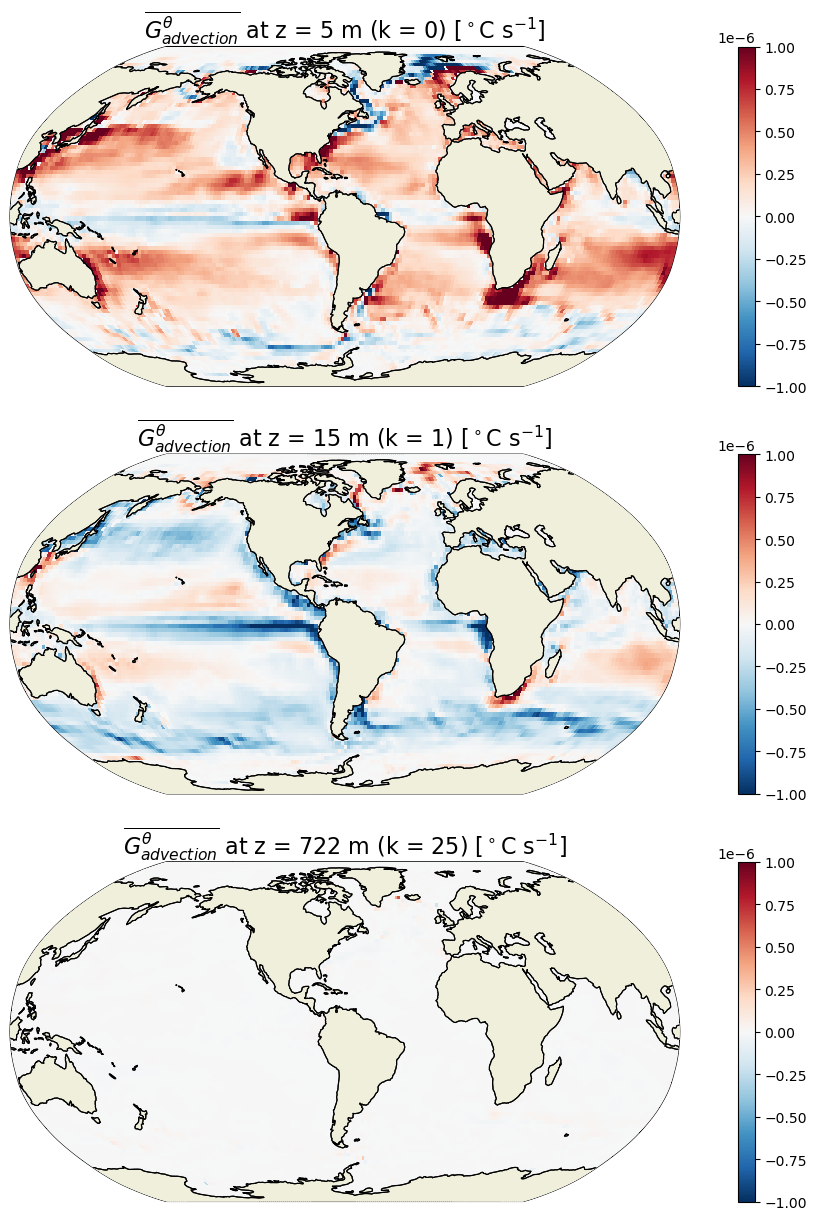

In [40]:
plt.figure(figsize=(15,15))

for idx, k in enumerate([0,1,25]):
    p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC,\
                                      monthly_tmean_aggregate(G_advection_compute,\
                                                              ds,ecco_vars_int_pickled,vol,month_length_weights,\
                                                              time_chunksize=1,k_isel=[k]),\
                                      show_colorbar=True,
                                      cmin=-1e-6, cmax=1e-6, cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2,
                                      subplot_grid=[3,1,idx+1]);
    p[1].set_title(r'$\overline{G^\theta_{advection}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
                   %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

# make the time G_adv term for all times

In [41]:
time_chunksize=1

In [45]:
# G_total

In [43]:
# Create a dataset with the shape (time: 12000, tile: 50, j: 90, i: 90, k: 13)
time = np.arange(12)
tile = np.arange(13)
j = np.arange(90)
i = np.arange(90)
k = np.arange(50)


In [53]:
# G_advection = G_advection_compute(ds,ecco_vars_int_pickled,vol,time_isel=None,k_isel=None)
# (ds,ecco_vars_int_pickled,vol,time_isel=curr_time_isel,k_isel=k_isel)

# for time_chunk in range(int(np.ceil(len(time_isel)/time_chunksize))):
G_advection = G_advection_compute(ds, ecco_vars_int_pickled, vol, time_isel=np.arange(12), k_isel=np.arange(50))
    # G_advection_results[t, :, :, :, :] = G_advection

# calculate tendency due to diffusion

In [56]:
# Set fluxes on land to zero (instead of NaN)
ds['DFxE_TH'] = ds.DFxE_TH.where(ecco_grid.hFacW.values > 0,0)
ds['DFyE_TH'] = ds.DFyE_TH.where(ecco_grid.hFacS.values > 0,0)
ds['DFrE_TH'] = ds.DFrE_TH.where(ecco_grid.hFacC.values > 0,0)
ds['DFrI_TH'] = ds.DFrI_TH.where(ecco_grid.hFacC.values > 0,0)

# tranpose dimensions
ds['DFrE_TH'] = ds.DFrE_TH.transpose('time','tile','k_l','j','i')
ds['DFrI_TH'] = ds.DFrI_TH.transpose('time','tile','k_l','j','i')

# re-chunk arrays for better performance
ds['DFxE_TH'] = ds['DFxE_TH'].chunk({'time':12,'k':-1,'tile':-1,'j':-1,'i_g':-1})
ds['DFyE_TH'] = ds['DFyE_TH'].chunk({'time':12,'k':-1,'tile':-1,'j_g':-1,'i':-1})
ds['DFrE_TH'] = ds['DFrE_TH'].chunk({'time':12,'k_l':-1,'tile':-1,'j':-1,'i':-1})
ds['DFrI_TH'] = ds['DFrI_TH'].chunk({'time':12,'k_l':-1,'tile':-1,'j':-1,'i':-1})

In [57]:
### Original code to compute G_diffusion is commented below
### (can use this if xgcm.diff_2d_vector is working properly
### and memory constraints allow)


# # compute horizontal components of flux divergence
# DFxyE_diff = grid.diff_2d_vector({'X' : ds.DFxE_TH, 'Y' : ds.DFyE_TH}, boundary = 'fill')

# # Convergence of horizontal diffusion (degC m^3/s)
# dif_hConvH = (-(DFxyE_diff['X'] + DFxyE_diff['Y']))

# # Convergence of vertical diffusion (degC m^3/s)
# dif_vConvH = grid.diff(DFrE_TH + DFrI_TH, 'Z', boundary='fill')

# # Sum horizontal and vertical convergences and divide by volume (degC/s)
# G_diffusion = (dif_hConvH + dif_vConvH)/vol


### End of original code block


# complete horizontal divergence calculation, 12 time indices (1 year) at a time

def G_diffusion_compute(ds,ecco_vars_int_pickled,vol,time_isel=None,k_isel=None):
    """Computes diffusion tendency for given time and k indices (k indices must be continuous, without gaps)"""

    if isinstance(time_isel,type(None)):
        time_isel = np.arange(0,ds.sizes['time'])
    if isinstance(k_isel,type(None)):
        k_isel = np.arange(0,ds.sizes['k'])

    if len(k_isel) > 1:
        if (np.nanmin(np.diff(np.asarray(k_isel))) < 1) or (np.nanmax(np.diff(np.asarray(k_isel))) > 1):
            raise ValueError('k_isel is not monotonically increasing or not continuous')


    # re-open source dataset
    ecco_vars_int = pickle.loads(ecco_vars_int_pickled)

    ## compute horizontal convergence

    DFxE_TH = ds.DFxE_TH.isel(time=time_isel,k=k_isel).compute()
    DFyE_TH = ds.DFyE_TH.isel(time=time_isel,k=k_isel).compute()
    DFxyE_diff = diff_2d_flux_llc90({'X': DFxE_TH,\
                                     'Y': DFyE_TH})

    # Convergence of horizontal advection (degC m^3/s)
    dif_hConvH = (-(DFxyE_diff['X'] + DFxyE_diff['Y']))

    # transpose dimensions
    dif_hConvH = dif_hConvH.transpose('time','tile','k','j','i')

    # restore time coordinate to DataArray if needed (can be lost in xgcm.diff_2d_vector operation)
    dif_hConvH = dif_hConvH.assign_coords({'time':ds.time[time_isel].data}).compute()

    ## compute vertical convergence

    if k_isel[-1] == ds.sizes['k']-1:
        DFrE_TH = ds.DFrE_TH.isel(time=time_isel,k_l=k_isel).pad(pad_width={'k_l':(0,1)},mode='constant',constant_values=0).compute()
        DFrI_TH = ds.DFrI_TH.isel(time=time_isel,k_l=k_isel).pad(pad_width={'k_l':(0,1)},mode='constant',constant_values=0).compute()
    else:
        DFrE_TH = ds.DFrE_TH.isel(time=time_isel,k_l=np.append(k_isel,k_isel[-1]+1)).compute()
        DFrI_TH = ds.DFrI_TH.isel(time=time_isel,k_l=np.append(k_isel,k_isel[-1]+1)).compute()
    dif_vConvH = (DFrE_TH + DFrI_TH).diff('k_l').rename({'k_l':'k'})
    dif_vConvH = dif_vConvH.assign_coords({'k':ds.k[k_isel].data})

    # restore time coordinate to DataArray if needed (can be lost in xgcm.diff_2d_vector operation)
    dif_vConvH = dif_vConvH.assign_coords({'time':ds.time[time_isel].data}).compute()

    ## Sum horizontal and vertical convergences and divide by volume (degC/s)
    G_diffusion = ((dif_hConvH + dif_vConvH)/vol).compute()

    # delete the variables where data was actually loaded into memory
    del DFxE_TH
    del DFyE_TH
    del dif_hConvH
    del DFrE_TH
    del DFrI_TH
    del dif_vConvH

    # close the original dataset where the fluxes were loaded from the source files (needed to clear the data from cache)
    ecco_vars_int.close()

    return G_diffusion

In [58]:
# mem_avail = psutil.virtual_memory().available
# print('Available memory:',mem_avail/(10**9),'GB')

# # chunk size to use when computing time mean with monthly_tmean_aggregate (not the same as dask chunksize)
# time_chunksize = int(np.round(mem_avail/(2**28)))
# time_chunksize = np.fmin(np.fmax(time_chunksize,1),ds.sizes['time'])
# print('Using time_chunksize =',time_chunksize)

In [109]:
# plt.figure(figsize=(15,15))

# for idx, k in enumerate([0,1,25]):
#     p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC,\
#                                       monthly_tmean_aggregate(G_diffusion_compute,\
#                                                               ds,ecco_vars_int_pickled,vol,month_length_weights,\
#                                                               time_chunksize=time_chunksize,k_isel=[k]),\
#                                       show_colorbar=True,
#                                       cmin=-3e-6, cmax=3e-6, cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2,
#                                       subplot_grid=[3,1,idx+1]);
#     p[1].set_title(r'$\overline{G^\theta_{diffusion}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
#                    %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

# calculate G_diffusion

In [60]:
G_diffusion = G_diffusion_compute(ds, ecco_vars_int_pickled, vol, time_isel=np.arange(12), k_isel=np.arange(50))
G_diffusion

<xarray.DataArray (time: 12, tile: 13, k: 50, j: 90, i: 90)> Size: 253MB
array([[[[[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [-1.17840239e-06, -1.07942742e-06, -1.01801277e-06, ...,
           -1.41464375e-06, -1.37123413e-06, -1.30043827e-06],
          [-1.18343382e-06, -1.07830226e-06, -1.00643808e-06, ...,
           -1.31100933e-06, -1.25636416e-06, -1.17936952e-06],
          [-1.13367855e-06, -1.08876191e-06, -1.08256700e-06, ...,
           -1.20894526e-06, -1.17068771e-06, -1.09442169e-06]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
...
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]]]]],
      dtype=float32)
Coordinates:
    Z        (k) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 96B 2010-01-16T12:00:00 ... 2010-12-16T12:...
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1

# calculate tendency due to forcing

In [61]:
Z = ecco_grid.Z.compute()
RF = np.concatenate([ecco_grid.Zp1.values[:-1],[np.nan]])

In [62]:
q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])

In [63]:
# Correction for the 200m cutoff
zCut = np.where(Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0

In [64]:
# Create xarray data arrays
q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])

In [65]:
## Land masks
# Make copy of hFacC
mskC = ecco_grid.hFacC.copy(deep=True).compute()

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1

In [66]:
# Shortwave flux below the surface (W/m^2)
forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*ds.oceQsw).transpose('time','tile','k','j','i')

In [67]:
# Surface heat flux (W/m^2)
forcH_surf = ((ds.TFLUX - (1-(q1[0]-q2[0]))*ds.oceQsw)\
              *mskC[0]).transpose('time','tile','j','i').assign_coords(k=0).expand_dims('k')

In [68]:
# Full-depth sea surface forcing (W/m^2)
forcH = xr.concat([forcH_surf,forcH_subsurf[:,:,1:]], dim='k').transpose('time','tile','k','j','i')

# load geothermal flux for the bottom

download from here : https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/raw/master/misc/geothermalFlux.bin

In [69]:
# # Load the geothermal heat flux using the routine 'read_llc_to_tiles'.
# geoflx_filename = 'geothermalFlux.bin'
# if exists(join(user_home_dir,'Downloads',geoflx_filename)):
#     geoflx_dir = join(user_home_dir,'Downloads')
# elif exists(join(user_home_dir,'ECCO-v4-Python-Tutorial','misc',geoflx_filename)):
#     geoflx_dir = join(user_home_dir,'ECCO-v4-Python-Tutorial','misc')
# elif exists(join(user_home_dir,'git_repos','ECCO-v4-Python-Tutorial','misc',geoflx_filename)):
#     geoflx_dir = join(user_home_dir,'git_repos','ECCO-v4-Python-Tutorial','misc')
# else:
#     raise FilePathError('Can not locate '+geoflx_filename+' in default directories.\n'\
#                         +'Please specify geoflx_dir.')
# # geoflx_dir = join(user_home_dir,'Downloads')
geoflx = ecco.read_llc_to_tiles('./', 'geothermalFlux.bin')

load_binary_array: loading file geothermalFlux.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [70]:
# Convert numpy array to an xarray DataArray with matching dimensions as the monthly mean fields
geoflx_llc = xr.DataArray(geoflx,coords={'tile': ecco_monthly_mean.tile.values,
                                         'j': ecco_monthly_mean.j.values,
                                         'i': ecco_monthly_mean.i.values},dims=['tile','j','i'])

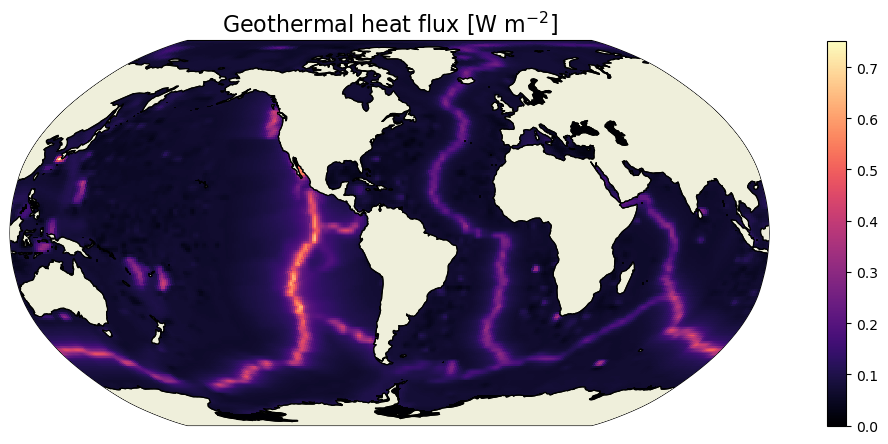

In [71]:
plt.figure(figsize=(15,5));

ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, geoflx_llc,show_colorbar=True,cmap='magma',
                              user_lon_0=-67, dx=0.2, dy=0.2)
plt.title(r'Geothermal heat flux [W m$^{-2}$]', fontsize=16)
plt.show()

# MASKING!

In [72]:
# Create 3d bathymetry mask
mskC_shifted = mskC.shift(k=-1)

mskC_shifted.values[-1,:,:,:] = 0
mskb = mskC - mskC_shifted

# Create 3d field of geothermal heat flux
geoflx3d = geoflx_llc * mskb.transpose('k','tile','j','i')
GEOFLX = geoflx3d.transpose('k','tile','j','i')
GEOFLX.attrs = {'standard_name': 'GEOFLX','long_name': 'Geothermal heat flux','units': 'W/m^2'}

# do total forcing

In [73]:
# Add geothermal heat flux to forcing field and convert from W/m^2 to degC/s
G_forcing = ((forcH + GEOFLX)/(rhoconst*c_p))/(ecco_grid.hFacC*ecco_grid.drF)

In [74]:
G_forcing_mean = (G_forcing*month_length_weights).sum('time')

CPU times: user 147 ms, sys: 4.48 ms, total: 151 ms
Wall time: 208 ms


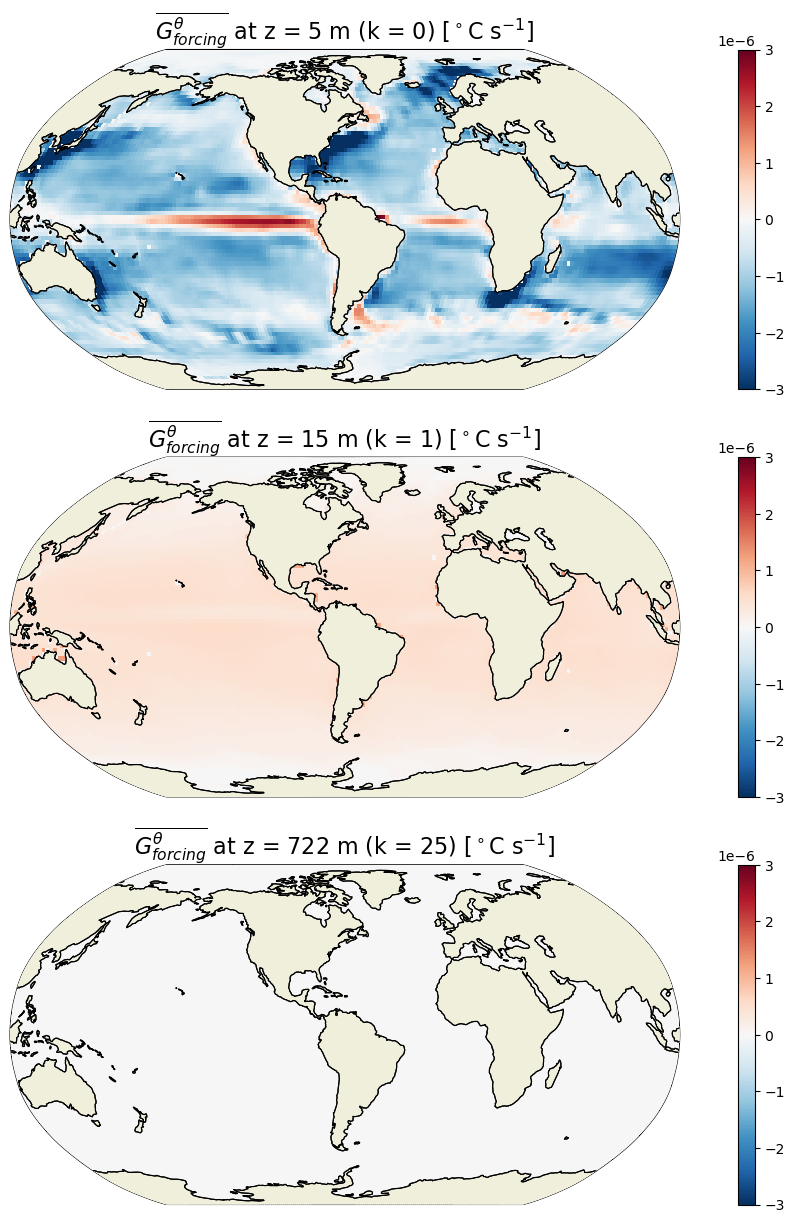

In [75]:
%%time

plt.figure(figsize=(15,15))

for idx, k in enumerate([0,1,25]):
    p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_forcing_mean.isel(k=k),show_colorbar=True,
                                      cmin=-3e-6, cmax=3e-6, cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2,
                                      subplot_grid=[3,1,idx+1]);
    p[1].set_title(r'$\overline{G^\theta_{forcing}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
                   %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

# save to a dataset

In [76]:
# varnames = ['G_total','G_advection','G_diffusion','G_forcing']

# G_total = G_total.transpose('time','tile','k','j','i')

# adv_diff_written = True

# ds_budg = xr.Dataset(data_vars={})
# for varname in varnames:
#     if varname not in globals():
#         # create empty dask arrays for G_advection and G_diffusion (to be written later)
#         import dask.array as da
#         ds_budg[varname] = (['time','tile','k','j','i'],\
#                             da.empty((ds.sizes['time'],13,50,90,90),dtype='float32',\
#                                     chunks=(1,13,50,90,90)))
#         adv_diff_written = False
#     else:
#         ds_budg[varname] = globals()[varname].chunk(chunks={'time':1,'tile':13,'k':50,'j':90,'i':90})

In [77]:
# # Add surface forcing (degC/s)
# ds_budg['Qnet'] = ((forcH /(rhoconst*c_p))\
#                   /(ecco_grid.hFacC*ecco_grid.drF)).chunk(chunks={'time':1,'tile':13,'k':50,'j':90,'i':90})

In [110]:
# # Add shortwave penetrative flux (degC/s)
# #Since we only are interested in the subsurface heat flux we need to zero out the top cell
# SWpen = ((forcH_subsurf /(rhoconst*c_p))/(ecco_grid.hFacC*ecco_grid.drF)).where(forcH_subsurf.k>0).fillna(0.)
# ds_budg['SWpen'] = SWpen.where(ecco_grid.hFacC>0).chunk(chunks={'time':1,'tile':13,'k':50,'j':90,'i':90})

In [183]:
# ds_budg.time.encoding = {}
# ds_budg = ds_budg.reset_coords(drop=True)

In [184]:
# import zarr


In [82]:
# # # save_dir is set to ~/Downloads below;
# # # change if you want to save somewhere else
# save_dir = join('./')

# # # first query how much storage is free
# # # the zarr file will occupy ~15 GB, so require 20 GB free storage as a buffer

# # import shutil
# # free_storage = shutil.disk_usage(save_dir).free
# # print(f'Free storage: {free_storage/(10**9)} GB')

# # # query how much memory is available
# # # (influences how this large archive will be computed and stored)
# # mem_avail = psutil.virtual_memory().available
# # print('Available memory:',mem_avail/(10**9),'GB')

In [83]:
# from dask.diagnostics import ProgressBar


In [84]:
# # %pdb on

# # ### Original code to save dataset to zarr archive

# # # zarr_save_location = join(save_dir,'eccov4r4_budg_heat')
# # # ds.to_zarr(zarr_save_location)

# # ### End of original code block


# # def zarr_archive_tloop(function,save_location,varname,\
# #                        ds,ecco_vars_int_pickled,vol,time_chunksize=1,time_isel=None,k_isel=None):
# #     """
# #     Compute array using function and save to zarr archive,
# #     by looping through time chunks of size time_chunksize.
# #     This has cleaner memory usage than just relying on dask chunking.
# #     """

# #     if isinstance(time_isel,type(None)):
# #         time_isel = np.arange(0,ds.sizes['time'])

# #     for time_chunk in range(int(np.ceil(len(time_isel)/time_chunksize))):
# #         if exists(save_location):
# #             ds_to_write = xr.open_zarr(save_location)
# #         curr_time_isel = time_isel[(time_chunksize*time_chunk):np.fmin(time_chunksize*(time_chunk+1),len(time_isel))]
# #         ds_to_write[varname] = da_replace_at_indices(ds_to_write[varname],\
# #                                                     {'time':str(curr_time_isel[0])+':'+str(curr_time_isel[-1]+1)},\
# #                                                     function(ds,ecco_vars_int_pickled,vol,time_isel=curr_time_isel,k_isel=k_isel))
# #         ds_to_write[varname].to_dataset().to_zarr(save_location,mode="a")
# #         ds_to_write.close()


# # the zarr archive will occupy ~15 GB, so require 20 GB free storage as a buffer
# zarr_save_location = join(save_dir,'eccov4r4_budg_heat')
# if True:
#     # chunk size to use when computing G_advection and G_diffusion (not the same as dask chunksize)
#     #time_chunksize = int(np.round(mem_avail/(10**9)))
#     # time_chunksize = ds.sizes['time']
#     #time_chunksize = np.fmin(np.fmax(time_chunksize,1),ds.sizes['time'])
#     # print('Using time_chunksize =',time_chunksize)
#     # if mem_avail >= 20*(10**9):
#     #     if not adv_diff_written:
#     ds_budg['G_advection'] = G_advection_compute(ds,ecco_vars_int_pickled,vol)
#     ds_budg['G_diffusion'] = G_diffusion_compute(ds,ecco_vars_int_pickled,vol)
#         # with ProgressBar():
#         #     ds_budg.to_zarr(zarr_save_location)
# #     else:
# #         ecco_vars_int.close()
# #         for varname in ds_budg.data_vars:
# #             ds_budg[varname].to_dataset().to_zarr(zarr_save_location,mode="a")
# #             if varname in ['G_advection','G_diffusion']:
# #                 zarr_archive_tloop(eval(varname+'_compute'),zarr_save_location,varname,\
# #                                    ds,ecco_vars_int_pickled,vol,time_chunksize=time_chunksize)
# # else:
# #     print('Insufficient storage to save global budget terms to disk as zarr')

In [85]:
# # to save budget as netcdf, set save_netcdf = True
# save_netcdf = True

# # the netcdf file will occupy ~53 GB, so require 60 GB free storage as a buffer
# if save_netcdf:
#     if free_storage >= 5*(10**9):
#         with ProgressBar():
#             ds.to_netcdf(join(save_dir,'eccov4r4_budg_heat.nc'), format='NETCDF4')
#     else:
#         print('Insufficient storage to save global budget terms to disk as netcdf')

# load from file

In [86]:
# ds_budg

In [87]:
# # G_budget = ds_budg
# G_total = ds_budg.G_total
# G_advection = ds_budg.G_advection
# G_diffusion = ds_budg.G_diffusion
# G_forcing = ds_budg.G_forcing
# Qnet = ds_budg.Qnet
# SWpen = ds_budg.SWpen

# the grand reveal?

In [88]:
# k = 0
# testADV = monthly_tmean_aggregate(G_diffusion_compute,ds,ecco_vars_int_pickled,vol,month_length_weights,time_chunksize=time_chunksize,k_isel=[k])
# testDF = monthly_tmean_aggregate(G_diffusion_compute,ds,ecco_vars_int_pickled,vol,month_length_weights,time_chunksize=time_chunksize,k_isel=[k])
# testFRC = G_forcing_mean

In [89]:
# testLHS = G_total_mean

In [90]:
# np.nansum(testLHS[0].values - (testADV[:,0].values + testDF[:,0].values + testFRC[:,0].values))
# ressurf = testLHS[0].values - (testADV[:,0].values + testDF[:,0].values + testFRC[:,0].values)


In [91]:
# plt.figure(figsize=(15,5))


# ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, ressurf, cmin=-5e-5, cmax=5e-5,show_colorbar=True, cmap='RdBu_r',dx=0.2, dy=0.2)
# plt.title(r'Residual $\partial \theta / \partial t$ [$^\circ$C s$^{-1}$]: RHS - LHS', fontsize=16)
# plt.show()

# double check the budget

In [176]:
# terms we have

# G_total
# G_advection
# G_diffusion
# G_forcing
res = G_total - G_advection - G_diffusion - G_forcing
# np.nansum(G_total[0] - G_advection[0] - G_diffusion[0] - G_forcing[0])

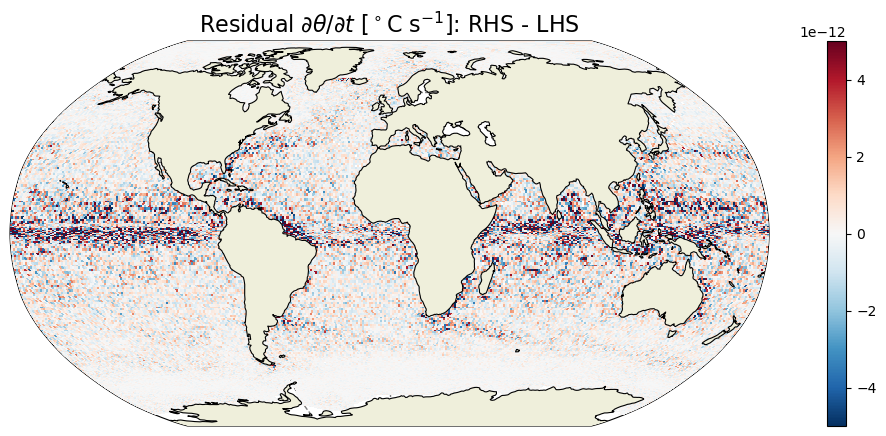

In [177]:
plt.figure(figsize=(15,5))

ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, res[0,:,0], cmin=-5e-12, cmax=5e-12,show_colorbar=True, cmap='RdBu_r',dx=0.2, dy=0.2)
plt.title(r'Residual $\partial \theta / \partial t$ [$^\circ$C s$^{-1}$]: RHS - LHS', fontsize=16)
plt.show()

# create the mask

In [178]:
ds1 = xr.open_dataset('/efs_ecco/wjiang/data_folder/ssh_climatology.nc')
grid = xr.open_dataset('/efs_ecco/wjiang/data_folder/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')

In [179]:
x_mask = np.logical_and(ds.XC>-75,ds.XC<-15)
y_mask = np.logical_and(ds.YC>45,ds.YC<70)
z_mask = grid.Z>-200
s_mask = ds1.SSH<-0.5
naive_mask = np.logical_and(s_mask,np.logical_and(np.logical_and(x_mask,y_mask),z_mask)).transpose('k','tile','j','i')

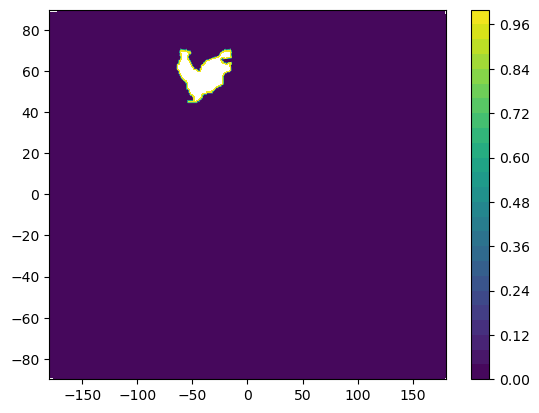

In [180]:
xx = np.array(ds.XC).ravel()
yy = np.array(ds.YC).ravel()
ssh = np.nan_to_num(np.array(naive_mask[0]).ravel())

plt.tricontourf(xx,yy,ssh,levels = 30)
plt.colorbar()

In [181]:
naive_mask = naive_mask.transpose( "tile", "k","j","i")
naive_mask = naive_mask.where(naive_mask, other=np.nan).astype(float)


In [185]:
np.where(~np.isnan(naive_mask))

(array([ 2,  2,  2, ..., 10, 10, 10]),
 array([ 0,  0,  0, ..., 16, 16, 16]),
 array([46, 47, 47, ..., 89, 89, 89]),
 array([ 0,  0,  1, ..., 41, 42, 43]))

In [186]:
res_mask

<xarray.DataArray 'SSH' (k: 50, tile: 13, j: 90, i: 90)> Size: 42MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    Z        (k) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03

# try to mask by the terms in the surface

In [ ]:
debug = False

In [183]:
# G_total
# G_advection
# G_diffusion
# G_forcing
# res          # time, tile, k, j, i

if debug:
    t = 0
    
    Gtot_mask = (naive_mask * G_total[0].values).transpose("k", "tile", "j","i")
    G_advection_mask = (naive_mask * G_advection[0].values).transpose("k", "tile", "j","i")
    G_diffusion_mask = (naive_mask * G_diffusion[0].values).transpose("k", "tile", "j","i")
    G_forcing_mask = (naive_mask * G_forcing[0].values).transpose("k", "tile", "j","i")
    res_mask = (naive_mask * res[0].values).transpose("k", "tile", "j","i")


    # do a plot
    fig = plt.figure()

    ax = plt.subplot(231)
    gtot = np.nan_to_num(Gtot_mask[0].values.ravel())
    cb = ax.tricontourf(xx,yy,gtot,levels = 500,cmap='seismic')#,vmin=-1e-6,vmax=1e-6)
    plt.colorbar(cb)
    
    ax = plt.subplot(232)
    gadv = np.nan_to_num(G_advection_mask[0].values.ravel())
    cb = ax.tricontourf(xx,yy,gadv,levels = 500,cmap='seismic')#,vmin=-1e-6,vmax=1e-6)
    plt.colorbar(cb)
    
    ax = plt.subplot(233)
    gdf = np.nan_to_num(G_diffusion_mask[0].values.ravel())
    cb = ax.tricontourf(xx,yy,gdf,levels = 500,cmap='seismic')#,vmin=-1e-6,vmax=1e-6)
    plt.colorbar(cb)
    
    ax = plt.subplot(234)
    gforc = np.nan_to_num(G_forcing_mask[0].values.ravel())
    cb = ax.tricontourf(xx,yy,gforc,levels = 500,cmap='seismic')#,vmin=-1e-6,vmax=1e-6)
    plt.colorbar(cb)
    
    ax = plt.subplot(235)
    gforc = np.nan_to_num(res_mask[0].values.ravel())
    cb = ax.tricontourf(xx,yy,gforc,levels = 500,cmap='seismic')#,vmin=-1e-6,vmax=1e-6)
    plt.colorbar(cb)

In [187]:
G_tot_ts = np.array([])
G_adv_ts = np.array([])
G_df_ts = np.array([])
G_surf_ts = np.array([])
G_res_ts = np.array([])


for t in range(12):
    print(ecco_monthly_snaps.time.values[t])
    
    # calculate the masked terms
    Gtot_mask = (naive_mask * G_total[t].values).transpose("k", "tile", "j","i")
    G_advection_mask = (naive_mask * G_advection[t].values).transpose("k", "tile", "j","i")
    G_diffusion_mask = (naive_mask * G_diffusion[t].values).transpose("k", "tile", "j","i")
    G_forcing_mask = (naive_mask * G_forcing[t].values).transpose("k", "tile", "j","i")
    res_mask = (naive_mask * res[t].values).transpose("k", "tile", "j","i")

    # calculate the nansum of this
    G_tot_ts = np.append(G_tot_ts, np.nansum(Gtot_mask))
    G_adv_ts = np.append(G_adv_ts, np.nansum(G_advection_mask))
    G_df_ts = np.append(G_df_ts, np.nansum(G_diffusion_mask))
    G_surf_ts = np.append(G_surf_ts, np.nansum(G_forcing_mask))
    G_res_ts = np.append(G_res_ts, np.nansum(res_mask))

0
1
2
3
4
5
6
7
8
9
10
11


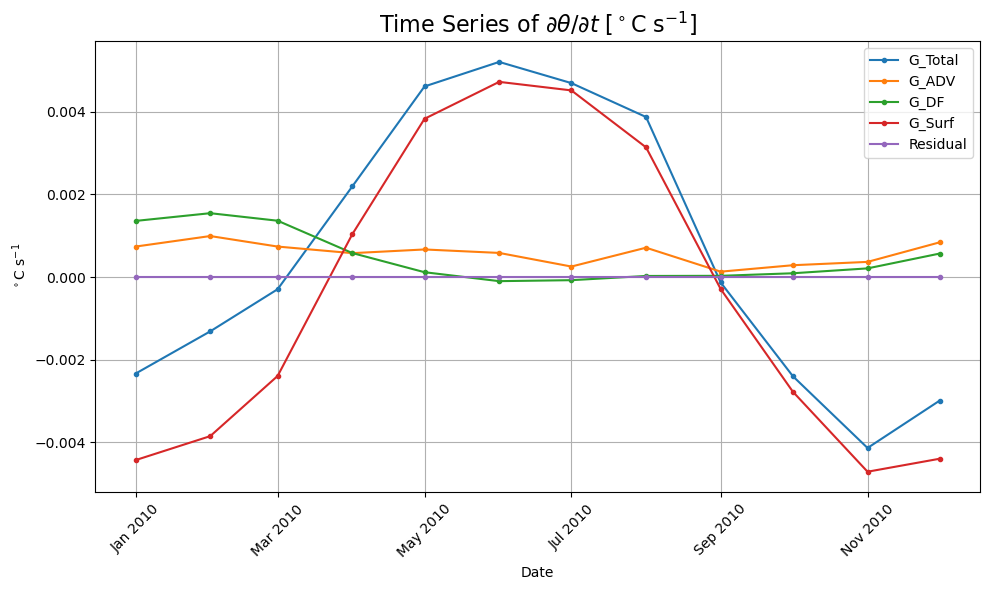

In [201]:
# times = np.a
# print(ecco_monthly_snaps.time.isel(time=[0, -1]).values)
# print(ecco_monthly_snaps.time.values[:-1])#.isel(time=[0, -1]).values)
timesteps = ecco_monthly_snaps.time.values[:-1]

plt.figure(figsize=(10, 6))

plt.plot(timesteps, G_tot_ts, label='G_Total', marker='.')
plt.plot(timesteps, G_adv_ts, label='G_ADV', marker='.')
plt.plot(timesteps, G_df_ts, label='G_DF', marker='.')
plt.plot(timesteps, G_surf_ts, label='G_Surf', marker='.')
plt.plot(timesteps, G_res_ts, label='Residual', marker='.')

# Formatting the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel(r'$^\circ$C s$^{-1}$')
plt.title(r'Time Series of $\partial \theta / \partial t$ [$^\circ$C s$^{-1}$]', fontsize=16)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()